<a href="https://colab.research.google.com/github/RevanthBN/Iris-Pupil-Segmentation/blob/main/Iris_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting the Google drive and cloning the github repo!**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Iris-Pupil-Segmentation/
!git pull

Mounted at /content/gdrive
/content/gdrive/My Drive/Iris-Pupil-Segmentation
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/RevanthBN/Iris-Pupil-Segmentation
   1eed53d..0b8ac15  main       -> origin/main
Updating 1eed53d..0b8ac15
Fast-forward
 Iris_segmentation.ipynb | 1032 +++++++++++++++++++++++++++++++++--------------
 1 file changed, 726 insertions(+), 306 deletions(-)


In [2]:
!pip install segmentation-models-pytorch

**Import all that is needed!**

In [100]:
# Global libraries
import os
from glob import glob

# Python libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import torch.nn.functional as F
import math

# Image processing
import cv2
from PIL import Image

# Pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader
import segmentation_models_pytorch as smp

# Others
import time
from sklearn.metrics import mean_absolute_error
cuda = torch.cuda.is_available()

**Additional global variables**



In [4]:
# Path for the training set
train_images_path = glob('training_set/images/*')
train_groundtruth_path = glob('training_set/groundtruths/*')
train_masks_path = glob('training_set/masks/*')

# Path for the test set
test_images_path = glob('testing_set/images/*')
test_groundtruth_path = glob('testing_set/groundtruths/*')
test_masks_path = glob('testing_set/masks/*')

# Image sizes for resizing
width = 256
height = 256
dim = (width, height)

**Hyperparameters to be tuned**

In [22]:
# Percentage for the train-val split
val_percent = 0.3

# Number of workers for dataloader
num_workers = 4 if cuda else 0 

# Batch size during training
batch_size = 20

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 1e-4

# Checkpoint path
checkpoint_path = "files/checkpoint.pth"


**Loading the dataset from the cloned drive folder**

In [6]:
class Iris(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        # Reading image 
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        image = image/255.0 ## (256, 256, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 256, 256)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        # Reading mask 
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
        mask = mask/255.0   ## (256, 256)
        mask = np.expand_dims(mask, axis=0) ## (256, 256)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

**Creating the datasets**

In [7]:
# Creating the datasets 
train_dataset = Iris(train_images_path, train_masks_path)
test_set = Iris(test_images_path, test_masks_path)

**Splitting the train dataset into Training and Validation sets by a 70-30 split with a manual seed of 0**

In [23]:
n_val = int(len(train_dataset) * val_percent)
n_train = len(train_dataset) - n_val
train_set, val_set = random_split(train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

data_str = f"Dataset Size:\nTrain: {len(train_set)} - Validation: {len(val_set)} - Test: {len(test_set)}\n"
print(data_str)

Dataset Size:
Train: 379 - Validation: 162 - Test: 10



**Loading the dataloader for the datasets**

In [24]:
# Training data
train_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
train_loader = DataLoader(train_set, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = DataLoader(test_set, **test_loader_args)


**Dice Loss Function** 

In [25]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


**Model definition**

In [26]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


In [27]:
device = torch.device("cuda" if cuda else "cpu")
# model = build_unet()
# model = smp.Unet('resnet34', encoder_weights="imagenet", classes=3, activation='softmax')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()
model = model.to(device)

**Utility Functions**

In [28]:
# Calculate the time taken 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**Training and Validation Functions**

In [29]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    print("Entered Training")
    model.train()
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    print("Entered Evaluation")
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

**Training and Evaluation of the model**

In [30]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

In [31]:
best_valid_loss = float("inf")

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, val_loader, loss_fn, device)

    # Saving the model
    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

Entered Training
Entered Evaluation
Valid loss improved from inf to 0.1038. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: 0.089
	 Val. Loss: 0.104

Entered Training
Entered Evaluation
Valid loss improved from 0.1038 to 0.1014. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.088
	 Val. Loss: 0.101

Entered Training
Entered Evaluation
Epoch: 03 | Epoch Time: 0m 13s
	Train Loss: 0.087
	 Val. Loss: 0.103

Entered Training
Entered Evaluation
Valid loss improved from 0.1014 to 0.1001. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.087
	 Val. Loss: 0.100

Entered Training
Entered Evaluation
Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: 0.086
	 Val. Loss: 0.102

Entered Training
Entered Evaluation
Valid loss improved from 0.1001 to 0.0996. Saving checkpoint: files/checkpoint.pth
Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 0.087
	 Val. Loss: 0.100

Entered Training
Entered Evaluation

**Testing function**

In [34]:
def predict(model, loader, loss_fn, device):
    epoch_loss = 0
    y_preds = []
    print("Entered Evaluation")
    with torch.no_grad():
        model.eval()
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            y_preds.append(y_pred)
        epoch_loss = epoch_loss/len(loader)
    return epoch_loss, y_preds


In [ ]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
test_loss, pred_masks = predict(model, test_loader, loss_fn, device)

**Visualization of the results**


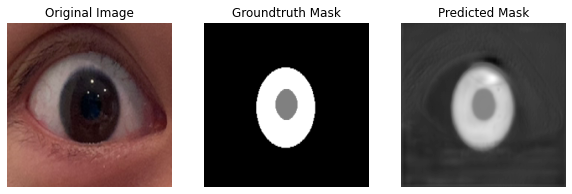

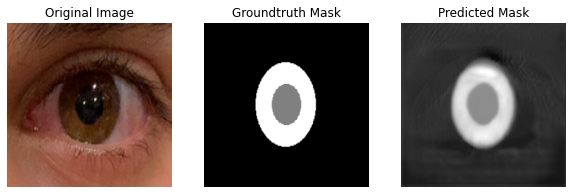

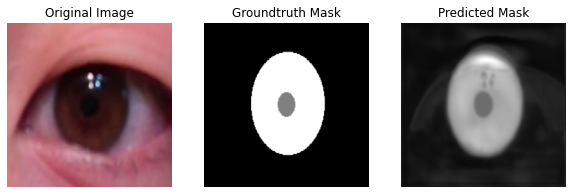

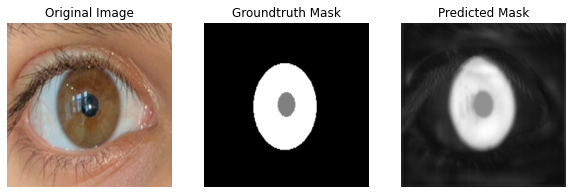

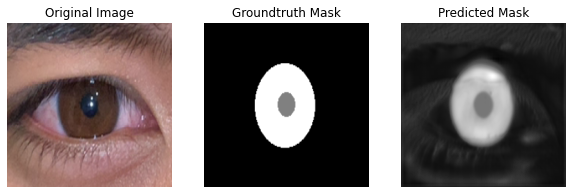

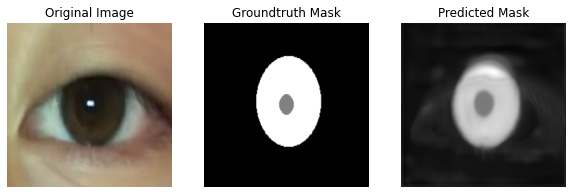

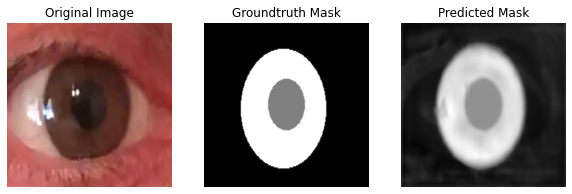

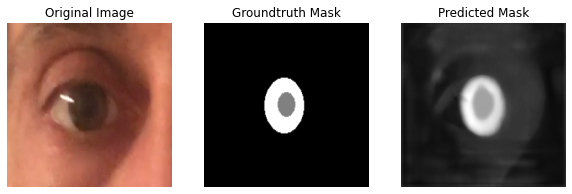

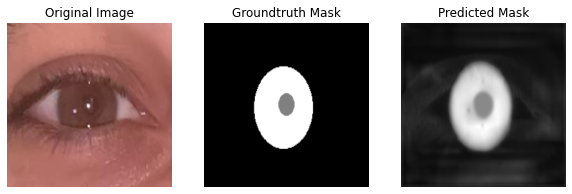

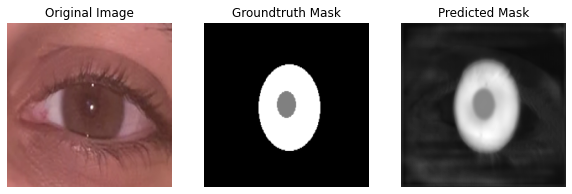

In [58]:
# len(test_set)
for i in range(len(test_set)):
  # Processing the original image
  test_original = test_set[i][0].cpu().numpy()
  test_original = np.squeeze(test_original) 
  test_original = np.transpose(test_original, (1, 2, 0))

  
  # Processing the groundtruth mask
  line = np.ones((256, 10, 3)) * 128
  test_image = test_set[i][1].cpu().numpy()
  test_image = np.squeeze(test_image, axis=0) 
  test_image = test_image*255

  # Processing the predicted mask
  pred_m = pred_masks[i].cpu().numpy()
  pred_m=np.squeeze(pred_m, axis=0)  
  pred_m=np.squeeze(pred_m, axis=0)  
  pred_m=pred_m*255
  pred_m_resized=cv2.resize(pred_m, (224,160));
  file_path = "testing_set/pred_masks/pred_im" + str(i) + ".png"
  cv2.imwrite(file_path, pred_m_resized)

  # Visuzalizing the predicted masks and actual masks alongside the original images
  plt.figure(figsize=(10,20))
  plt.subplot(1,3,1)
  plt.imshow(test_original)
  plt.axis("off")
  plt.title("Original Image")
  plt.subplot(1,3,2)
  plt.imshow(test_image, cmap='gray')
  plt.axis("off")
  plt.title("Groundtruth Mask")
  plt.subplot(1,3,3)
  plt.imshow(pred_m, cmap='gray')
  plt.axis("off")
  plt.title("Predicted Mask")

  

**Evaluation Metrics - Compute the Average Iris diameter accuracy**


In [60]:
print("The Dice BCE score is: "+str(1-test_loss))

The Dice BCE score is: 0.8925166122615338


**Estimate the Iris Diameter**

In [ ]:
pred_masks_path = glob('testing_set/pred_masks/*')
pred_iris_dia = []
for pred_mask in pred_masks_path:

  imgG = cv2.imread(pred_mask, 0)


  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2

  # Find the binary image with edges from the thresholded image
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)

  # Estimating the Iris diameter

  # Process the image for circles using the Hough transform
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=30, param2=15, minRadius=0, maxRadius=50)

  # Determine if any circles were found
  if circles is None:
      print("No circles found")
  else:
      # convert the (x, y) coordinates and radius of the
      # circles to integers
      circles = np.round(circles[0, :]).astype("int")

      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgO, (x, y), r, (255, 2550, 0), 1)
          print("The x,y coordinates of iris are: ("+str(x)+","+str(y)+")")
          print("The diameter of the iris is: "+str(r*2))
          pred_iris_dia.append(r*2)

In [ ]:
gt_masks_path = glob('testing_set/masks/*')
gt_iris_dia = []
for gt_mask in gt_masks_path:

  imgG = cv2.imread(gt_mask, 0)


  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2

  # Find the binary image with edges from the thresholded image
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)

  # Estimating the Iris diameter

  # Process the image for circles using the Hough transform
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=30, param2=15, minRadius=0, maxRadius=50)

  # Determine if any circles were found
  if circles is None:
      print("No circles found")
  else:
      # convert the (x, y) coordinates and radius of the
      # circles to integers
      circles = np.round(circles[0, :]).astype("int")

      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgO, (x, y), r, (255, 2550, 0), 1)
          print("The x,y coordinates of iris are: ("+str(x)+","+str(y)+")")
          print("The diameter of the iris is: "+str(r*2))
          gt_iris_dia.append(r*2)

**Estimate the Pupil Diameter**

In [ ]:
pred_masks_path = glob('testing_set/pred_masks/*')
pred_pupil_dia = []
for pred_mask in pred_masks_path:

  imgG = cv2.imread(pred_mask, 0)


  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2

  # Find the binary image with edges from the thresholded image
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)

  # Estimating the pupil diameter

  # Process the image for circles using the Hough transform
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=20, param2=22, minRadius=0, maxRadius=25)

  # Determine if any circles were found
  if circles is None:
      print("Pupil detection failed")
      pred_pupil_dia.append(10*2)
  else:
      # convert the (x, y) coordinates and radius of the
      # circles to integers
      circles = np.round(circles[0, :]).astype("int")

      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgO, (x, y), r, (255, 2550, 0), 1)
          print("The x,y coordinates of pupil are: ("+str(x)+","+str(y)+")")
          print("The diameter of the pupil is: "+str(r*2))
          pred_pupil_dia.append(r*2)
          cv2.imwrite("houghOutput.png", imgG)

In [ ]:
gt_masks_path = glob('testing_set/masks/*')
gt_pupil_dia = []
for gt_mask in gt_masks_path:

  imgG = cv2.imread(gt_mask, 0)


  thV, thI = cv2.threshold(imgG, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  highTH = thV
  lowTH = thV / 2

  # Find the binary image with edges from the thresholded image
  imgE = cv2.Canny(imgG, threshold1=lowTH, threshold2=highTH)

  # Estimating the pupil diameter

  # Process the image for circles using the Hough transform
  circles = cv2.HoughCircles(imgE, cv2.HOUGH_GRADIENT, 1, 40,
                            param1=20, param2=22, minRadius=0, maxRadius=25)

  # Determine if any circles were found
  if circles is None:
      print("Pupil detection failed")
      gt_pupil_dia.append(10*2)
  else:
      # convert the (x, y) coordinates and radius of the
      # circles to integers
      circles = np.round(circles[0, :]).astype("int")

      # draw the circles
      for (x, y, r) in circles:
          cv2.circle(imgO, (x, y), r, (255, 2550, 0), 1)
          print("The x,y coordinates of pupil are: ("+str(x)+","+str(y)+")")
          print("The diameter of the pupil is: "+str(r*2))
          gt_pupil_dia.append(r*2)
          # cv2.imwrite("houghOutput.png", imgG)

In [112]:
# Predicted diameters
p_iris=np.array(pred_iris_dia)
p_pupil=np.array(pred_pupil_dia)
# Groundtruth diameters
gt_iris=np.array(gt_iris_dia)
gt_pupil=np.array(gt_pupil_dia)

**Mean % Iris Diameter Error**

In [132]:
m = np.mean((abs(p_iris-gt_iris)/gt_iris) * 100)
ans = f'Mean Absolute % Iris diameter error is: {m:.3f} %\n'
print(ans)

Mean Absolute % Iris diameter error is: 15.870 %



**Mean % Pupil Diameter Error**

In [133]:
m = np.mean((abs(p_pupil-gt_pupil)/gt_pupil) * 100)
ans = f'Mean Absolute % Pupil diameter error is: {m:.3f} %\n'
print(ans)

Mean Absolute % Pupil diameter error is: 23.278 %

